In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.stats import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
from jetstream_hugo.hotspells import *
from simpsom.plots import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

ERROR 1: PROJ: proj_create_from_database: Open of /storage/homefs/hb22g102/mambaforge/envs/env11/share/proj failed


In [2]:
exp_s = Experiment(
    "ERA5", "plev", "s", "6H", (1940, 2022), "JJA", -80, 30, 20, 80, [200, 250, 300], None, None, None, reduce_da=True
)
exp_s_extended = Experiment(
    "ERA5", "plev", "s", "6H", (1940, 2022), [5, 6, 7, 8, 9], -80, 30, 20, 80, [200, 250, 300], None, None, None, reduce_da=True
)
exp_T = Experiment(
    "ERA5", "surf", "t", "6H", (1940, 2022), [5, 6, 7, 8, 9], -30, 40, 30, 75, "all", 'hourofyear', {'hourofyear': ('win', 60)}, None,
)
da_T = exp_T.da

In [3]:
da_cee = exp_T.select_heat_wave_cluster(10, 6)
JA_mask = np.isin(da_cee.time.dt.month, [7, 8])
heat_waves_ts, heat_waves, hs_da = heat_waves_from_t(da_cee, fill_holes=True, output_type="both")

/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/hotspells.py:35: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  mask = heat_waves.astype('datetime64[h]').values
/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/hotspells.py:50: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArr

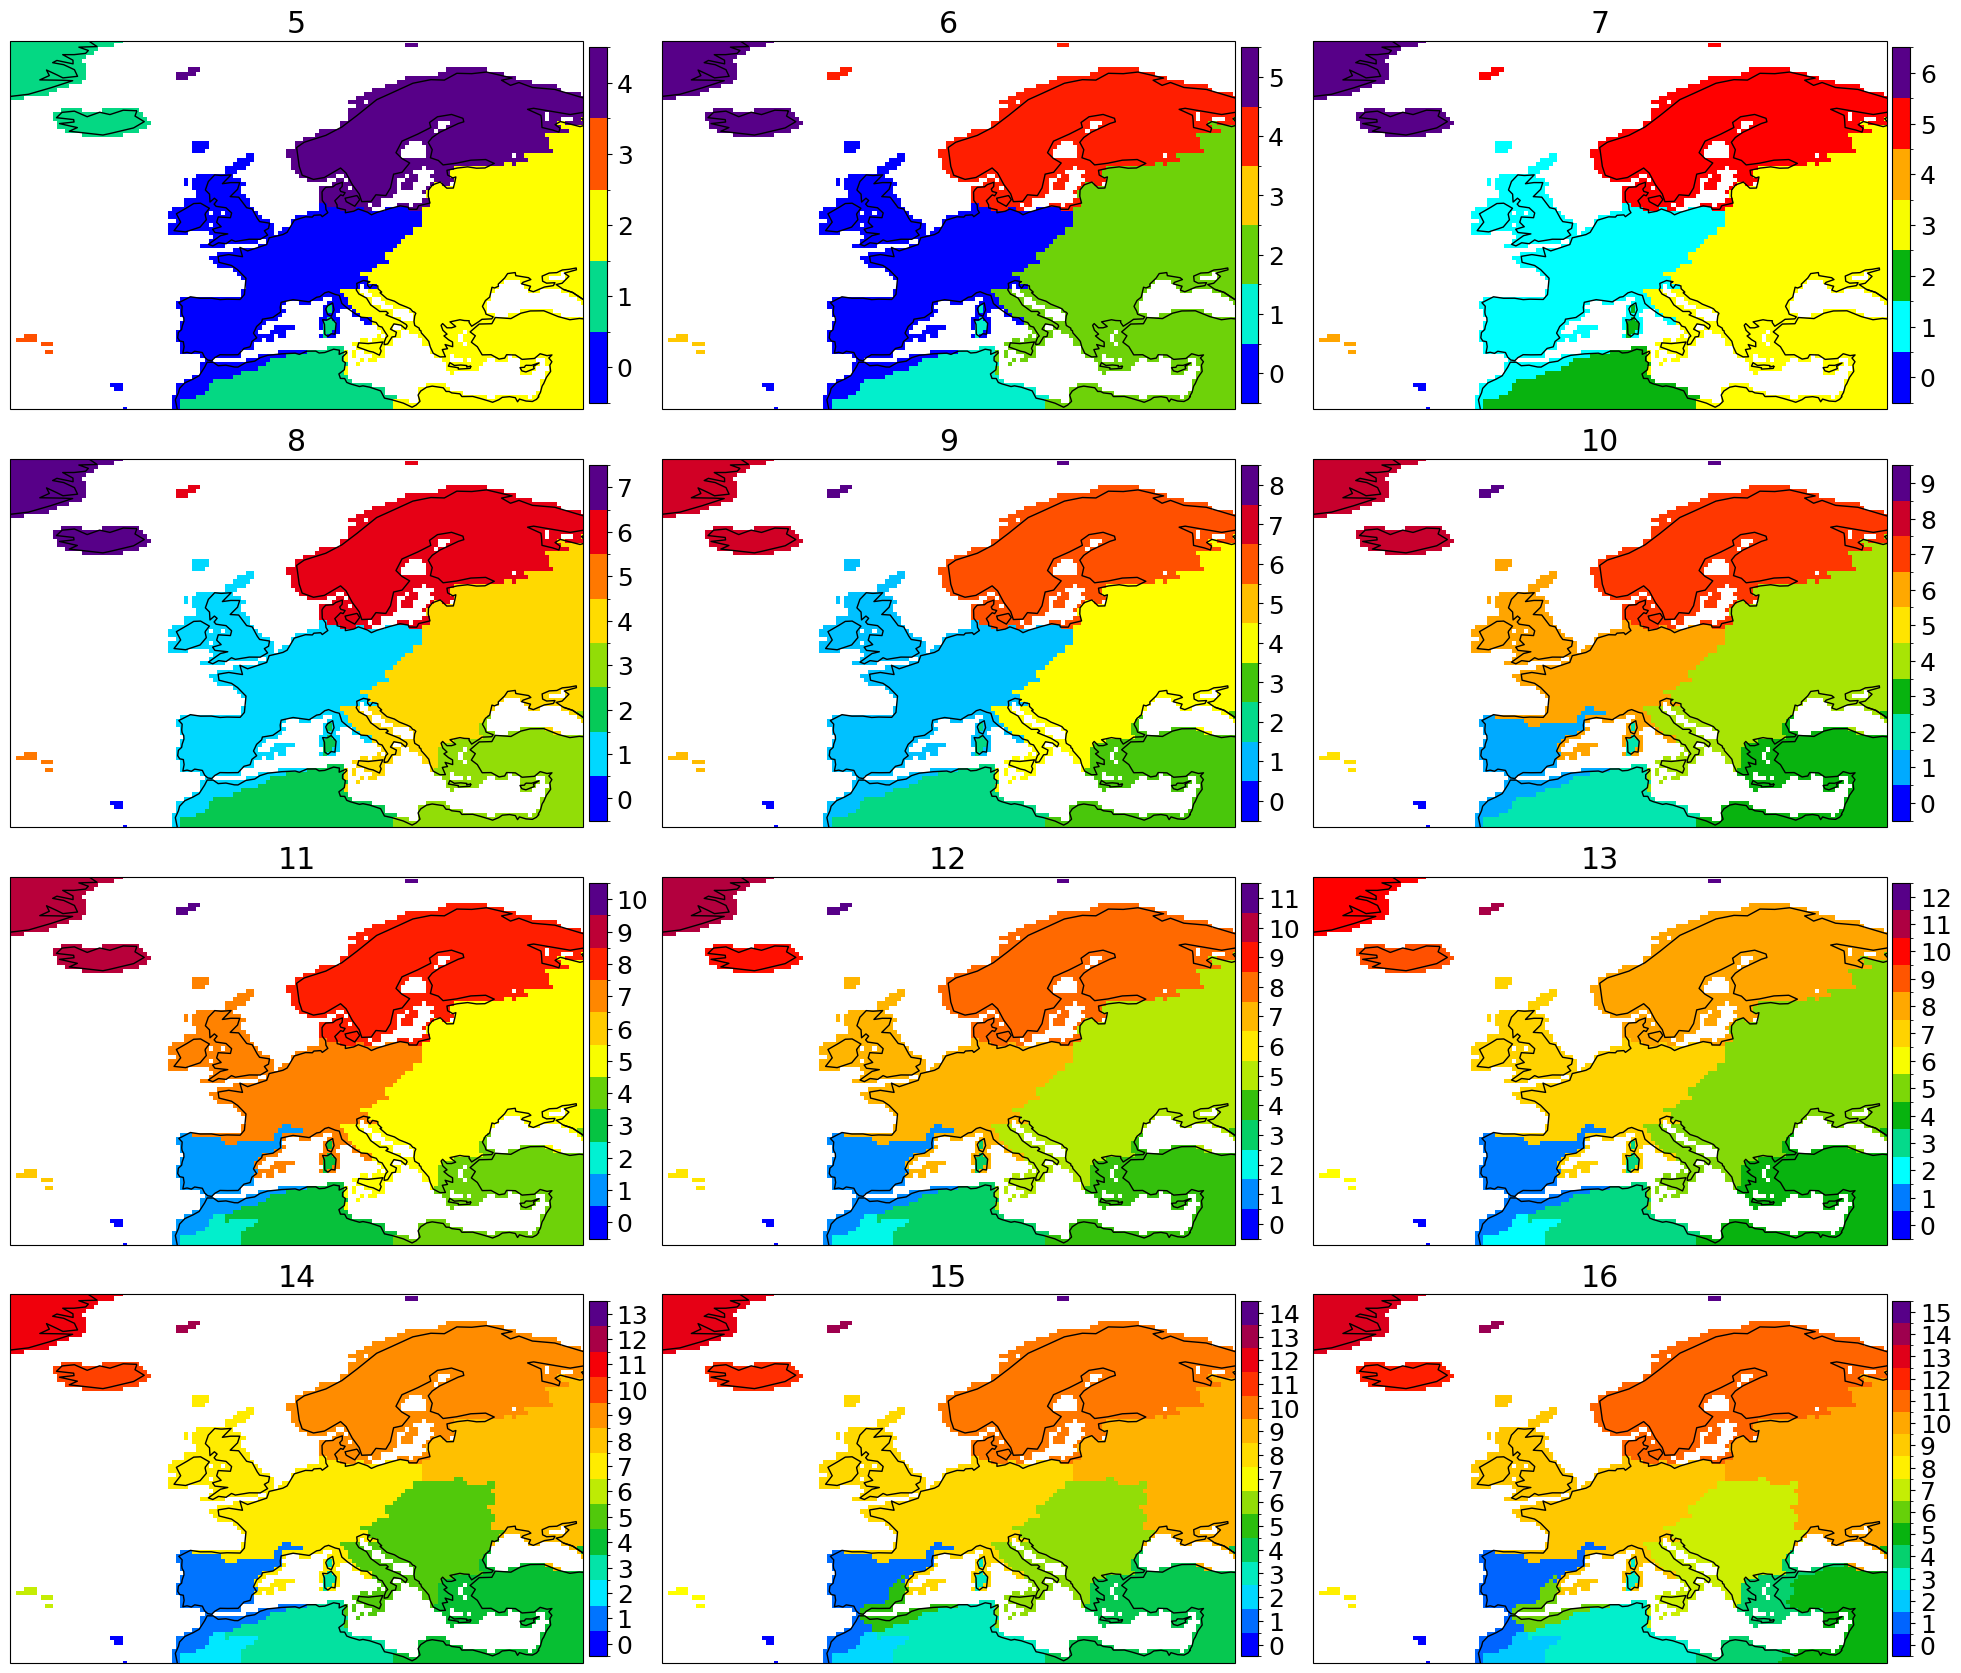

In [30]:
clu = Clusterplot(3, 3, exp_T.region)
Z = exp_T.heat_wave_linkage()
cmap = colormaps.BlAqGrYeOrReVi200
mask = get_land_mask()
lon, lat = da_T.lon.values, da_T.lat.values
mask = mask.sel(lon=lon, lat=lat)
stack_dims = {'lat_lon': ('lat', 'lon')}
mask_flat = mask.stack(stack_dims)
for i, n_clu in enumerate(range(5, 14)):
    clusters = cut_tree(Z, n_clusters=n_clu)[:, 0]
    clusters_da = np.zeros(mask_flat.shape, dtype=float)
    clusters_da[:] = np.nan
    clusters_da = mask_flat.copy(data=clusters_da)
    clusters_da[mask_flat] = clusters
    unique_clusters = np.unique(clusters)
    norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
    every = n_clu // 20 + 1
    clusters_da.unstack().plot(
        ax=clu.axes[i],
        cmap=cmap,
        add_colorbar=False,
        add_labels=False
    )
    clu.axes[i].set_title(n_clu)
    im = ScalarMappable(cmap=cmap, norm=norm)
    clu.fig.colorbar(im, ax=clu.axes[i], ticks=np.arange(0, n_clu, every), shrink=0.92, pad=0.01)

In [4]:
net, centers, labels = exp_s_extended.som_cluster(
    8,
    6,
    200,
    return_type=RAW_REALSPACE,
    force=False,
    train_kwargs=dict(train_algo="batch", epochs=100, start_learning_rate=0.05),
)

populations = net.compute_populations()
coords = net.neighborhoods.coordinates
centers_all_jets = find_jets(xr.Dataset({"s": centers}))
centers_props = compute_all_jet_props(centers_all_jets, centers)
centers_props_ds_uncat = props_to_ds(centers_props, centers.cluster)
centers_props_ds = categorize_ds_jets(centers_props_ds_uncat)

100%|██████████| 48/48 [00:03<00:00, 13.88it/s]


# Van Straaten SOM prediction

In [6]:
lags = [0, 3, 7, 15]
timescales = [1, 7, 15]
predictors = xr.DataArray(
    net.neighborhoods.distances[net.bmus],
    coords={'time': labels.time.values, 'center': np.arange(net.n_nodes)}
).sel(time=labels.time.dt.year < 2023)
da_cee = da_cee.assign_coords(hourofyear=compute_hourofyear(da_cee))
da_cee = da_cee.expand_dims(axis=1, **dict(timescale=timescales)).copy(deep=True)
for n_days in tqdm(timescales[1:]):
    for year in np.unique(da_cee.time.dt.year):
        year_mask = da_cee.time.dt.year == year
        da_cee.loc[year_mask, n_days] = window_smoothing(da_cee.loc[year_mask, 1], dim='hourofyear', winsize=4 * n_days, center=False).shift(time=- 4 * n_days + 1)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


In [7]:
from sklearn.metrics import brier_score_loss
JA_mask = np.isin(da_cee.time.dt.month, [7, 8])
da_cee_targets = da_cee > da_cee.quantile(0.66, dim='time')
da_cee_targets = da_cee_targets.sel(time=JA_mask, timescale=[1, 7, 15])
base_pred = da_cee_targets.copy(data=np.zeros(da_cee_targets.shape, dtype=float))
base_pred = base_pred.assign_coords(
    f1_score=        ('timescale', np.zeros(len(base_pred.timescale))),
    roc_score=       ('timescale', np.zeros(len(base_pred.timescale))),
    accuracy=        ('timescale', np.zeros(len(base_pred.timescale))),
    brier_score_loss=('timescale', np.zeros(len(base_pred.timescale))),
)
X_base = (da_cee_targets.time.values - da_cee_targets.time.values[0]).astype('timedelta64[D]').astype(int)[:, None]
for timescale in da_cee_targets.timescale.values:
    y = da_cee_targets.loc[:, timescale].values
    X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=0.2) 
    lr = LogisticRegression(class_weight=None).fit(X_train, y_train)
    y_pred_prob = lr.predict_proba(X_test)[:, 1]
    y_pred = lr.predict(X_test)
    base_pred.loc[:, timescale] = lr.predict_proba(X_base)[:, 1]
    base_pred.roc_score.loc[timescale] = roc_auc_score(y_test, y_pred_prob)
    base_pred.brier_score_loss.loc[timescale] = brier_score_loss(y_test, y_pred_prob)
    base_pred.f1_score.loc[timescale] = f1_score(y_test, y_pred)
    base_pred.accuracy.loc[timescale] = balanced_accuracy_score(y_test, y_pred)

In [8]:
predictors = predictors.expand_dims(axis=-1, **dict(lag=lags)).copy(deep=True)
for lag in lags[1:]:
    for year in np.unique(predictors.time.dt.year):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            year_mask = predictors.time.dt.year == year
            predictors.loc[year_mask, :, lag] = predictors.loc[year_mask, :, lag].shift(time=lag).copy()
predictors = predictors[JA_mask]

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap

targets = da_cee_targets - base_pred
full_pred = da_cee_targets.expand_dims(axis=-1, **dict(lag=lags)).copy(deep=True).astype(float)
full_pred[:] = 0
full_pred = full_pred.assign_coords(
    f1_score=(('timescale', 'lag'), np.zeros(full_pred.shape[1:])),
    roc_score=(('timescale', 'lag'), np.zeros(full_pred.shape[1:])),
    accuracy=(('timescale', 'lag'), np.zeros(full_pred.shape[1:])),
    brier_score_loss=(('timescale', 'lag'), np.zeros(full_pred.shape[1:])),
)
coords = {
    'center': predictors.center.values,
    'target_timescale': full_pred.timescale.values,
    'lag': predictors.lag.values,
}
permutation_importances = xr.DataArray(np.zeros([len(c) for c in coords.values()]), coords=coords)
shap_importances = {}
for timescale, lag in tqdm(product(targets.timescale.values, lags), total=len(targets.timescale.values) * len(lags)):
    if timescale not in shap_importances:
        shap_importances[timescale] = {}
    # timescale of target, lag of driver 
    y_orig = da_cee_targets.loc[:, timescale]
    y = targets.loc[:, timescale]
    X = predictors.sel(lag=lag).values
    X_train, X_test, y_train, y_test, _, y_orig_test, _, idx_test = train_test_split(X, y, y_orig, np.arange(base_pred.shape[0]), test_size=0.2) 
    rfr = RandomForestRegressor(max_depth=10, n_jobs=N_WORKERS).fit(X_train, y_train)
    y_pred_prob = rfr.predict(X_test) + base_pred.loc[:, timescale].values[idx_test]
    y_pred_prob = np.clip(y_pred_prob, 0, 1)
    y_pred = y_pred_prob > 0.5
    full_pred.loc[:, timescale, lag] = rfr.predict(X) + base_pred.loc[:, timescale]
    full_pred.roc_score.loc[timescale, lag] = roc_auc_score(y_orig_test, y_pred_prob)
    full_pred.brier_score_loss.loc[timescale, lag] = brier_score_loss(y_orig_test, y_pred_prob)
    full_pred.f1_score.loc[timescale, lag] = f1_score(y_orig_test, y_pred)
    full_pred.accuracy.loc[timescale, lag] = balanced_accuracy_score(y_orig_test, y_pred)
    r = permutation_importance(rfr, X_test, y_test, n_repeats=20, n_jobs=N_WORKERS)
    r = r.importances_mean
    permutation_importances.loc[:, timescale, lag] = r
    X = pd.DataFrame(X, index=predictors.time.values, columns=predictors.center.values)
    shap_values = shap.TreeExplainer(rfr, X.iloc[np.random.randint(0, X.shape[0], size=200), :])(X, check_additivity=False)
    shap_importances[timescale][lag] = shap_values

100%|██████████| 12/12 [25:34<00:00, 127.86s/it]00]        


In [10]:
shap_abs_mean_importances = permutation_importances.copy()
shap_mean_importances = permutation_importances.copy()
shap_correlations = permutation_importances.copy()
for timescale, lag in product(targets.timescale.values, lags):
    shap_values = shap_importances[timescale][lag]
    shap_abs_mean = shap_values.abs.mean(axis=0).values
    shap_abs_mean_importances.loc[:, timescale, lag] = shap_abs_mean
    shap_mean = shap_values.mean(axis=0).values
    shap_mean_importances.loc[:, timescale, lag] = shap_mean
    importance_correlation = np.diag(np.corrcoef(shap_values.values, shap_values.data, rowvar=False)[shap_values.shape[1]:, :shap_values.shape[1]])
    shap_correlations.loc[:, timescale, lag] = importance_correlation

In [11]:
full_pred.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_full_pred.nc')
permutation_importances.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_permutation_importances.nc')
save_pickle(shap_importances, '/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_shap_importances.pkl')
shap_abs_mean_importances.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_shap_abs_mean_importances.nc')
shap_mean_importances.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_shap_mean_importances.nc')
shap_correlations.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_shap_correlations.nc')

In [35]:
full_pred = xr.open_dataarray('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_full_pred.nc')
permutation_importances = xr.open_dataarray('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_permutation_importances.nc')
shap_importances = load_pickle('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_shap_importances.pkl')
shap_abs_mean_importances = xr.open_dataarray('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_shap_abs_mean_importances.nc')
shap_correlations = xr.open_dataarray('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/SOM_shap_correlations.nc')

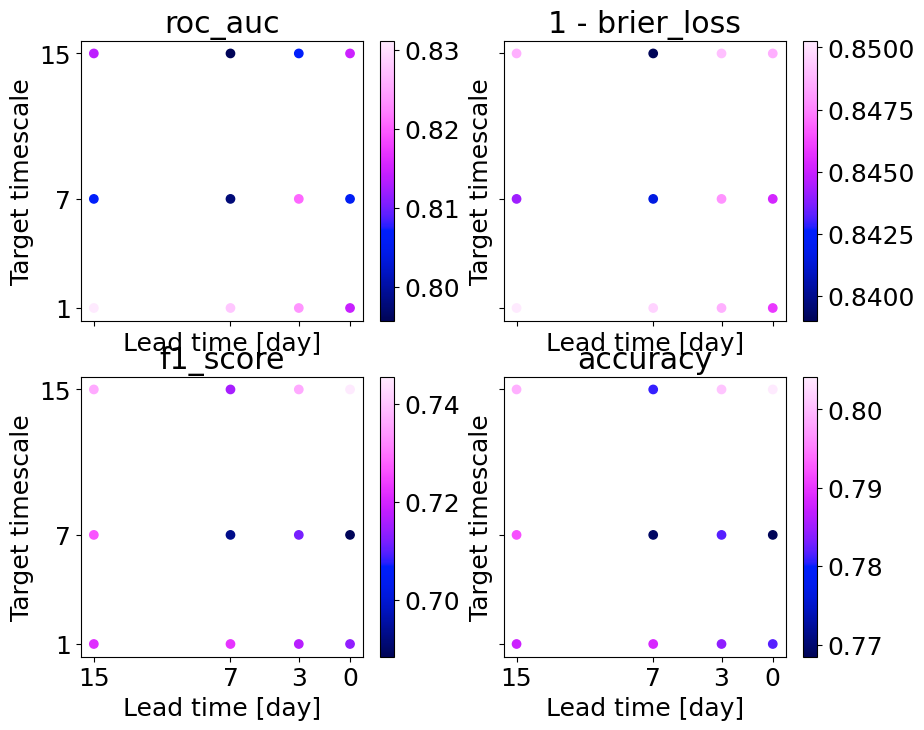

In [13]:
x = full_pred.lag.values
y = full_pred.timescale.values
scores = {
    'roc_auc': full_pred.roc_score.values,
    '1 - brier_loss': 1 - full_pred.brier_score_loss.values,
    'f1_score': full_pred.f1_score.values,
    'accuracy': full_pred.accuracy.values,
}
cmap = colormaps.cet_l_bmw1
fig, axes = plt.subplots(2, len(scores) // 2, figsize=(10, 8), sharex='all', sharey='all')
for (scorename, scores_), ax in zip(scores.items(), axes.ravel()):
    im = ax.scatter(*np.meshgrid(x, y), c=scores_.ravel(), cmap=cmap)
    ax.set_title(scorename)
    ax.set_xlabel('Lead time [day]')
    ax.set_xticks(np.unique(x))
    _ = ax.set_ylabel('Target timescale')
    _ = ax.set_yticks(np.unique(y))
    fig.colorbar(im, ax=ax)
ax.invert_xaxis()

invalid value encountered in sqrt


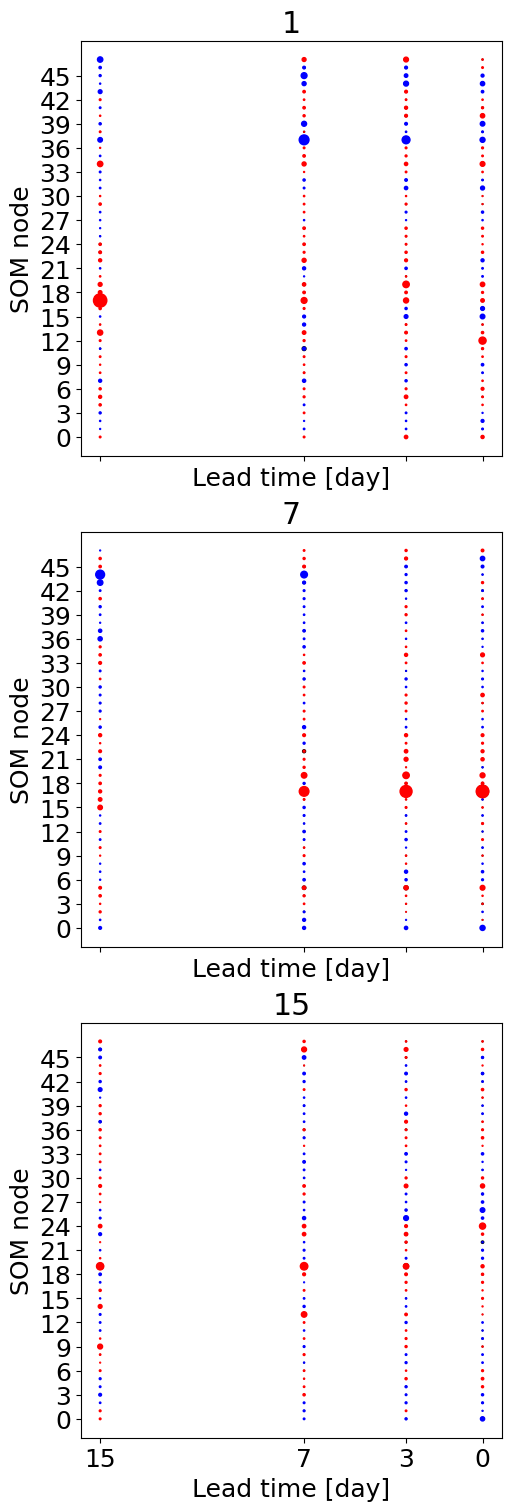

In [14]:
x = shap_abs_mean_importances.lag.values
y = shap_abs_mean_importances.center.values
fig, axes = plt.subplots(3, 1, figsize=(5, 15), constrained_layout=True, sharey='all', sharex='all')
target_timescales = shap_abs_mean_importances.target_timescale.values
for target_timescale, ax in zip(target_timescales, axes):
    s1 = permutation_importances.loc[:, target_timescale, :].values
    s2 = shap_abs_mean_importances.loc[:, target_timescale, :].values
    s3 = shap_correlations.loc[:, target_timescale, :].values
    ax.scatter(*np.meshgrid(x, y), s=s1 * 2000, color='black')#, vmin=vmin, vmax=vmax, cmap=colormaps.cet_l_bmw)
    ax.scatter(*np.meshgrid(x, y), s=s2 * 2000, c=np.sign(s3), cmap='bwr', vmin=-1, vmax=1)
    ax.set_xlabel('Lead time [day]')
    ax.set_xticks(np.unique(x))
    ax.set_ylabel('SOM node')
    ax.set_yticks(np.unique(y)[::3])
    ax.set_title(f'{target_timescale}')
ax.invert_xaxis()

# Relative time series

In [5]:
predictors = xr.DataArray(
    labels_to_mask(labels),
    coords={'time': labels.time.values, 'center': np.arange(net.n_nodes)}
).sel(time=labels.time.dt.year < 2023)
da_cee = da_cee.sel(time=da_cee.time.dt.year < 2023)

/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/hotspells.py:35: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  mask = heat_waves.astype('datetime64[h]').values
/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/hotspells.py:50: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArr

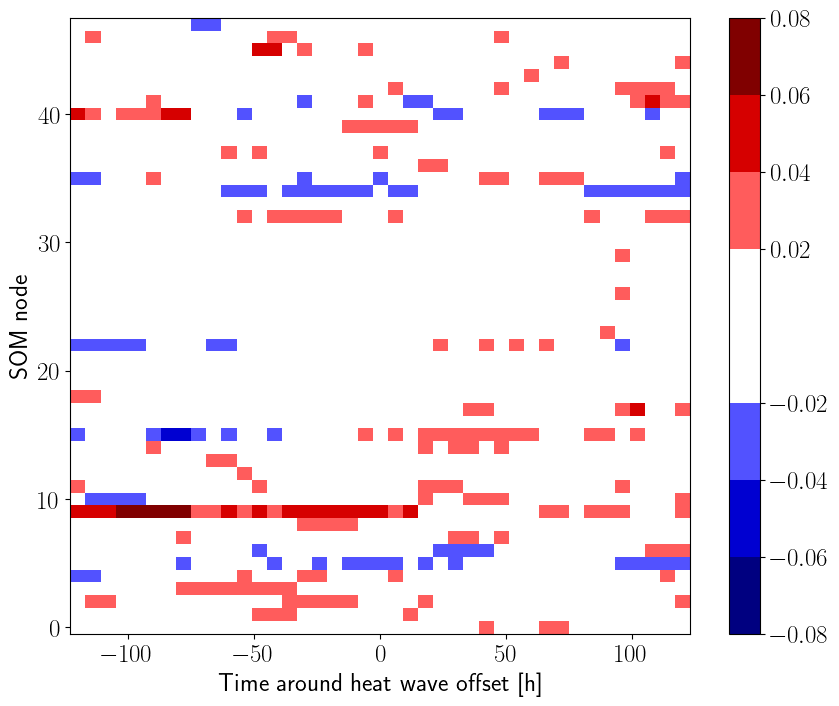

In [27]:
days_before = 5
predictors_masked = mask_from_t(
    da_cee, predictors.astype(float), q=.9,
    time_before=pd.Timedelta(days_before, 'D')
)
predictors_masked = predictors_masked.sel(time_around_beg=slice(pd.Timedelta(-24 * days_before, 'h'), pd.Timedelta(24 * days_before, 'h')))
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
dt = (labels.time.values[1] - labels.time.values[0]).astype('timedelta64[h]')
x = predictors_masked.time_around_beg.values.astype('timedelta64[h]')
y = predictors_masked.center.values
freq_anoms = predictors_masked.mean(dim='heat_wave').values.T
freq_anoms = freq_anoms - predictors.mean(dim='time').values[:, None]
cmap = colormaps.BlWhRe
im = ax.pcolormesh(
    x.astype(int), 
    y, 
    freq_anoms, 
    shading='nearest',
    cmap=cmap,
    norm=BoundaryNorm(np.delete(np.arange(-0.08, 0.1, 0.02), 4), cmap.N)
)
ax.set_xlabel("Time around heat wave offset [h]")
ax.set_ylabel("SOM node")
plt.colorbar(im, spacing="proportional")

# On a yearly basis

In [14]:
def get_frequency_anomaly(hs_da: xr.DataArray, labels: xr.DataArray | NDArray, year: int | Sequence = YEARSPL_EXT, len_thresh: int = 1): 
    if isinstance(year, int):
        year = [year]
    mask = labels_to_mask(labels)
    mask_thisyear = labels.time.dt.year.isin(year)
    unique_labels, counts = np.unique(labels.sel(time=mask_thisyear), return_counts=True)
    thisyear_pops = np.zeros(mask.shape[1], dtype=int)
    thisyear_pops[unique_labels[1:] - 1] = counts[1:]
    thisyear_probas = thisyear_pops / np.sum(thisyear_pops)
    hs_da = hs_da.sel(time=mask_thisyear)
    conditional_probas = (
        np.sum(
            (hs_da > len_thresh).values[:, None] & mask[mask_thisyear.values], axis=0
        )
        / np.sum((hs_da > len_thresh).values, axis=0)
    )
    return conditional_probas - thisyear_probas[:]

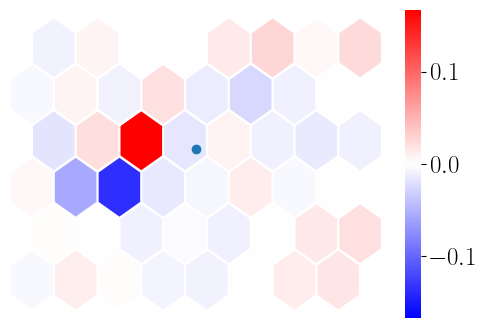

In [15]:
to_plot = get_frequency_anomaly(hs_da, labels)
kwargs = {
    "cmap": 'bwr',
    "norm": Normalize(- np.amax(np.abs(to_plot)), np.amax(np.abs(to_plot)))
}
fig, ax = plt.subplots(figsize=(6, 4))
fig, ax = net.plot_on_map(
    to_plot,
    smooth_sigma=0,
    show=False,
    draw_cbar=True,
    fig=fig,
    ax=ax,
    **kwargs,
)
x, y = net.neighborhoods.coordinates[labels.loc[np.concatenate(heat_waves_ts)].values].mean(axis=0)
ax.scatter(x, y)
plt.show()

## Events basis

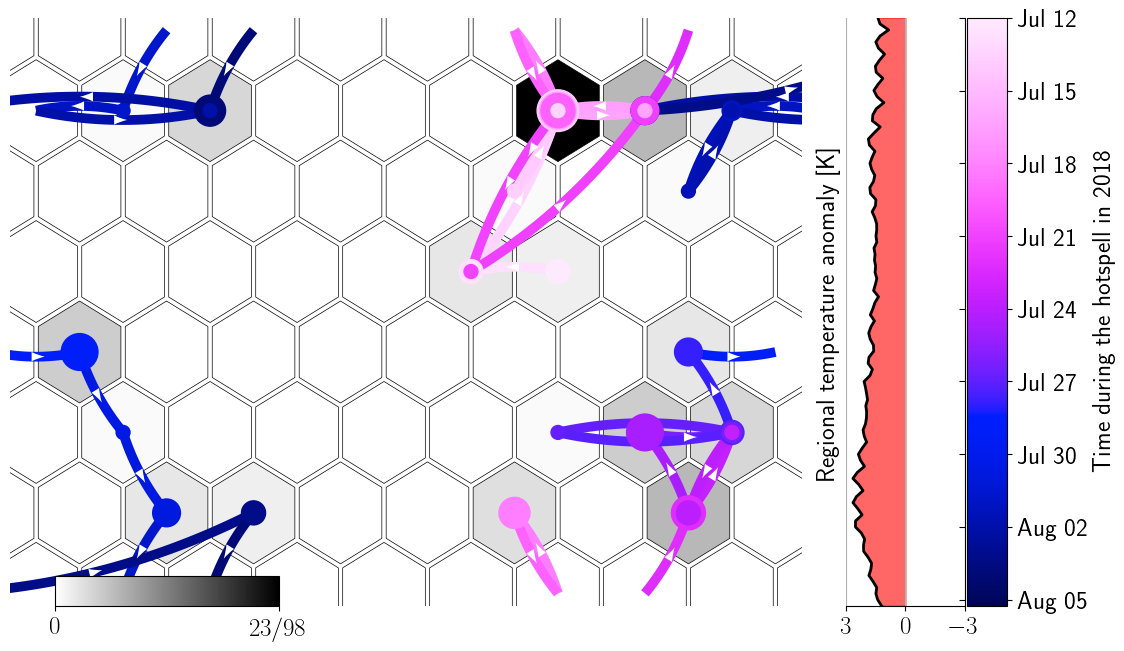

In [22]:
season = da_cee.sel(time=(da_cee.time.dt.year == 1999) & (da_cee.time.dt.month == 8)).time.values
heat_wave = heat_waves_ts[-21]
labels.attrs["width"] = net.width
labels.attrs["height"] = net.height
labels.attrs["n_nodes"] = net.n_nodes
fig, ax, cbar = plt_traj_hotspell(heat_wave, labels, da_cee)
# fig.savefig(f'{FIGURES}/som_props/hotspell_2022.png', dpi=300, bbox_inches='tight')

# Max. residence time comparison

In [71]:
heat_waves_stays = {'longest_stay': [], 'ref_distrib': [], 'significant': []}
for heat_wave in heat_waves_ts:
    len_ = len(heat_wave)
    start_month = heat_wave[0].month
    start_times = np.where(labels.time.dt.month==start_month)[0]
    indices = start_times[:, None] + np.arange(len_)[None, :]
    from scipy.stats import mode
    try:
        these_bmus = labels.values[indices]
    except IndexError:
        continue
    counts = mode(np.cumsum(np.diff(these_bmus, axis=1) != 0, axis=1), axis=1)[1]
    these_bmus = labels.loc[heat_waves_ts[-2]].values
    heat_wave_longest_stay = mode(np.cumsum(np.diff(these_bmus) != 0))[1]
    heat_waves_stays['longest_stay'].append(heat_wave_longest_stay)
    heat_waves_stays['ref_distrib'].append(np.sort(counts))
    heat_waves_stays['significant'].append(heat_wave_longest_stay >= np.quantile(counts, 0.95))
np.where(heat_waves_stays['significant'])[0]

array([], dtype=int64)

# More or less jumps ?

In [72]:
da_cee.resample(time='1Y').mean().values

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


array([-0.257, -0.382, -0.375, -0.171, -0.248,  0.002,  0.164,  0.304,
       -0.435, -0.248,  0.035, -0.226, -0.307,  0.1  , -0.234, -0.127,
       -0.677, -0.315, -0.386, -0.129,  0.022, -0.106, -0.704, -0.21 ,
       -0.406, -0.785, -0.429, -0.25 , -0.581, -0.424, -0.283, -0.518,
       -0.33 , -0.274, -0.489, -0.287, -0.57 , -0.722, -0.853, -0.462,
       -0.388, -0.345, -0.464, -0.248, -0.404, -0.352, -0.419, -0.424,
        0.083,  0.09 ,  0.051, -0.113, -0.169, -0.524,  0.015,  0.152,
       -0.304,  0.111,  0.203,  0.549,  0.122,  0.445,  0.621,  0.913,
        0.361,  0.477,  0.803,  0.464,  0.391,  0.562,  0.806,  0.556,
        0.588,  0.72 ,  0.806,  0.522,  1.017,  0.705,  1.155,  0.754,
        0.736,  0.922,  1.1  ], dtype=float32)

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


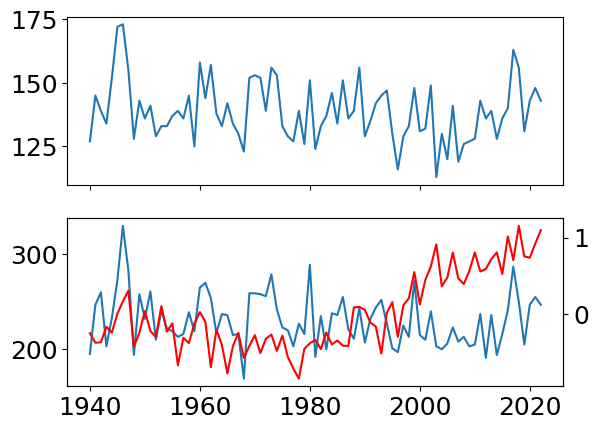

In [77]:
dist_mat = net.neighborhoods.distances
years = np.unique(labels.time.dt.year.values)
jumps_per_year = []
distance_per_year = []
for year in years:
    nodes = labels.sel(time=labels.time.dt.year == year).values
    jumps = np.diag(dist_mat[nodes[:-1], :][:, nodes[1:]])
    jumps_per_year.append(np.sum(jumps > 0))
    distance_per_year.append(np.sum(jumps))
fig, axes = plt.subplots(2, 1, sharex='all')
axes[0].plot(years, jumps_per_year)
axes[1].plot(years, distance_per_year)
axes[1].twinx().plot(years, da_cee.resample(time='1Y').mean().values, color='red')

In [8]:
jumps = bmus_da[:-1].copy(data=dist_mat[bmus_da[:-1], bmus_da[1:]])

In [ ]:
heat_waves_jumps = {'distance': [], 'ref_distrib': [], 'significative': []}
for heat_wave in heat_waves_ts:
    len_ = len(heat_wave)
    start_month = heat_wave[0].month
    start_times = np.where(bmus_da.time.dt.month==start_month)[0]
    indices = start_times[:, None] + np.arange(len_)[None, :]
    ref_distrib = np.sum(jumps.values[indices], axis=1)
    compare_against = np.quantile(ref_distrib, q=0.01)
    heat_wave_distance = np.sum(jumps.loc[heat_wave].values)
    heat_waves_jumps['distance'].append(heat_wave_distance)
    heat_waves_jumps['ref_distrib'].append(np.sort(ref_distrib))
    heat_waves_jumps['significative'].append(heat_wave_distance <= compare_against)
np.where(heat_waves_jumps['significative'])[0]

array([31])

In [ ]:
yearbreaks = np.sum(bmus_da.time.dt.year == bmus_da.time.dt.year[0]).item()
possible_tuples = [
    (i, j) for i, j in product(range(net.n_nodes), range(net.n_nodes))
]
possible_tuples = np.asarray(possible_tuples, dtype='i,i')
indices = [i for n in range(len(np.unique(bmus_da.time.dt.year))) for i in range(n * yearbreaks, (n + 1) * yearbreaks - 1)]
transitions = np.zeros(len(da_s.time), dtype='i, i')
transitions[indices] = [(net.bmus[i], net.bmus[i + 1]) for i in indices]
transition_masks = transitions[:, None] == possible_tuples[None, :]
unique_transitions, counts = np.unique(transitions, return_counts=True)
trans_mat = np.zeros((net.n_nodes, net.n_nodes))
trans_mat[unique_transitions['f0'], unique_transitions['f1']] = counts
sort_order = np.argsort(counts)[::-1][:50]
sort_order_1 = [i for i in sort_order if unique_transitions[i][0] == unique_transitions[i][1]]
sort_order_2 = [i for i in sort_order if unique_transitions[i][0] != unique_transitions[i][1]]

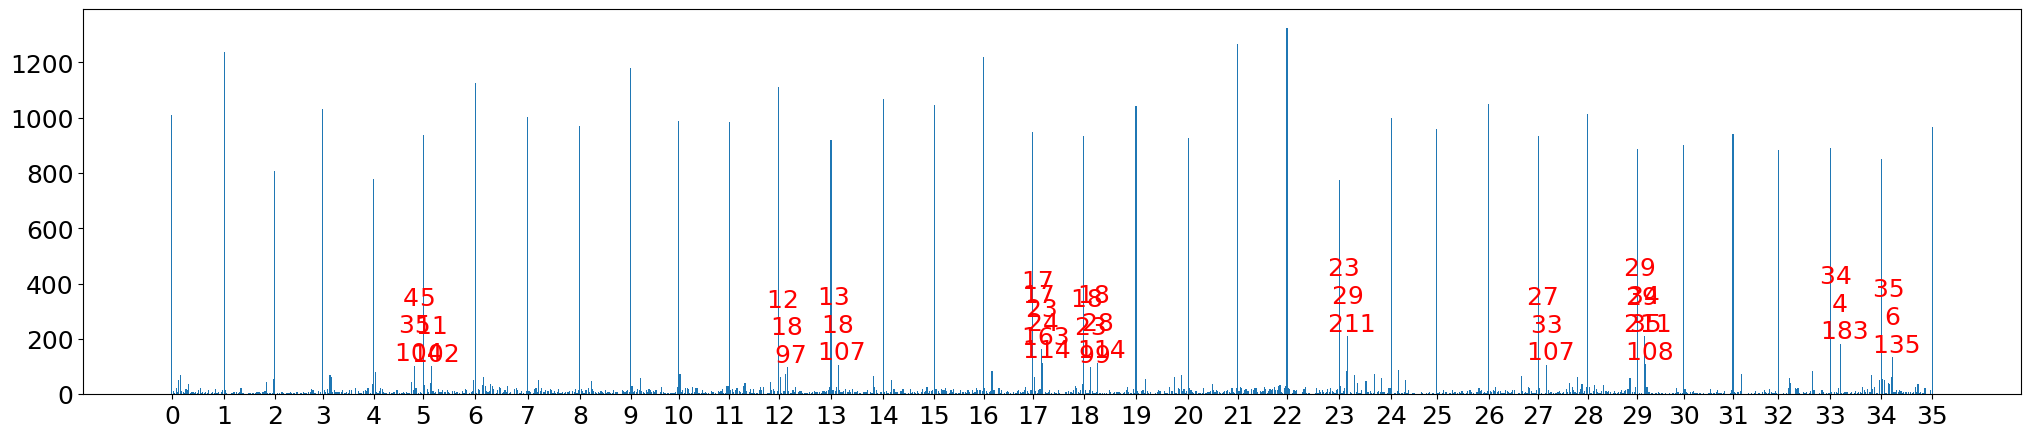

In [ ]:
fig, ax = plt.subplots(figsize=(25, 5))
ax.bar(np.arange(len(counts)), counts)
ax.set_xticks(sort_order_1, unique_transitions['f0'][sort_order_1])
for i in sort_order_2:
    xy = (i, counts[i])
    xytext = (i, counts[i])
    plt.annotate(f'{unique_transitions[i][0]} \n {unique_transitions[i][1]} \n {counts[i]}', xy=xy, xytext=xytext, ha='center', va='bottom', color='red')

In [ ]:
unique_transitions_heat_waves, counts_heat_waves = np.unique(transitions[np.where(np.isin(bmus_da.time.values, np.concatenate(heat_waves_ts)))[0]], return_counts=True)

In [ ]:
all_to_hs = np.isin(unique_transitions, unique_transitions_heat_waves)
counts_heat_waves - counts[all_to_hs]
# counts_heat_waves

array([ -984,   -51,   -67,   -14,   -37,    -6,   -19,    -6,    -3,
        -988,   -67,   -60,   -15,    -8,    -5,   -15,   -12,   -15,
         -22,  -775,    -9,   -11,    -5,  -929,   -31,  -101,   -12,
         -17,   -13,   -10,   -50, -1071,   -30,   -59,   -28,   -10,
          -7,   -11,   -29,   -17,   -13,    -6,   -18,   -22,   -13,
         -12,  -987,    -8,    -4,   -11,   -19,   -19,  -963,   -10,
         -16, -1129,   -28,   -57,   -11,   -12,   -12,  -957,   -16,
         -26,    -9,   -21,   -22,    -9,   -16,   -27,  -963,   -19,
         -14,   -22,   -27,    -3,   -17,    -5,   -16,   -25,   -42,
         -12, -1071,   -59,    -5,   -10,   -73,   -91,   -25,    -6,
          -5,   -15,   -24,  -905,  -102,   -16,    -9,    -7,    -6,
         -63,    -7, -1046,    -4,   -49,    -6,   -10,   -12,   -13,
       -1030,   -16,   -15,   -17,    -8,    -6,    -5,   -20,   -14,
       -1175,   -19,   -12,   -13,    -3,    -7,    -9,   -23,    -3,
         -11,  -910,

In [13]:
bmus_da.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/bmus_da.nc')
np.save('/storage/homefs/hb22g102/persistent-extremes-era5/results/heat_waves_cee.npy', heat_waves)

# Whole period, attribution and conditional probas

In [28]:
time_before = pd.Timedelta(3, "D")
heat_waves_ts, heat_waves, hs_da = heat_waves_from_t(da_cee, fill_holes=True, output_type="both", time_before=time_before)
dt = heat_waves_ts[0][1] - heat_waves_ts[0][0]
nind = int(2 * time_before / dt)
clustered_hotspells = [[] for _ in range(net.n_nodes)]
for j, heat_wave in enumerate(heat_waves_ts):
    unique, counts = np.unique(labels.loc[heat_wave[:nind]], return_counts=True)
    where = np.argmax(counts)
    clustered_hotspells[int(unique[where])].append((len(heat_wave), j, counts[where]))

/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/hotspells.py:35: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  mask = heat_waves.astype('datetime64[h]').values
/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/hotspells.py:50: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArr

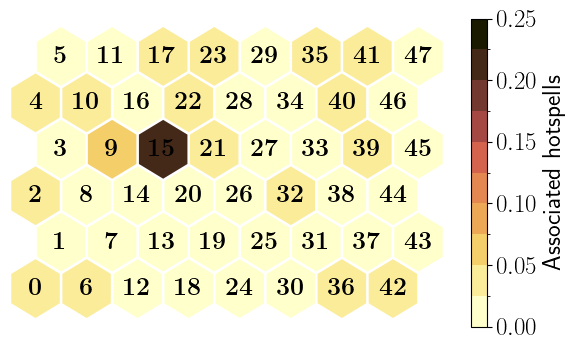

In [38]:
to_plot = np.asarray([len(cluhs) for cluhs in clustered_hotspells]) / len(heat_waves)
cmap = colormaps.lajolla
kwargs = {
    "cmap": cmap,
    "norm": BoundaryNorm(np.arange(0, 0.275, 0.025), cmap.N)
}
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
fig, ax = net.plot_on_map(
    to_plot,
    smooth_sigma=0,
    fig=fig,
    ax=ax,
    draw_cbar=False,
    **kwargs,
)
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=ax, label="Associated hotspells")
for i, c in enumerate(coords):
    x, y = c
    ax.text(x, y, r"$\mathbf{" + f"{i}" + r"}$", va="center", ha="center", color="Black")
plt.show()

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


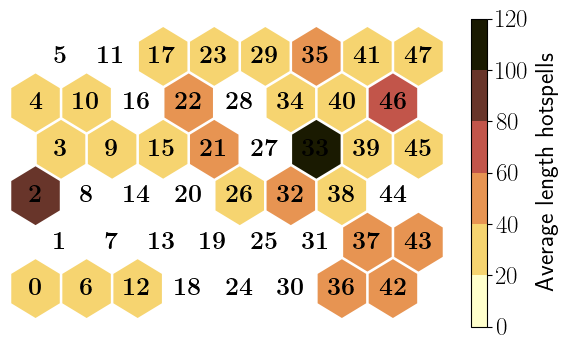

In [39]:
to_plot = np.asarray([np.mean([hs[0] for hs in cluhs]) for cluhs in clustered_hotspells])
cmap = colormaps.lajolla
kwargs = {
    "cmap": cmap,
    "norm": BoundaryNorm(np.arange(0, 140, 20), cmap.N)
}
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
fig, ax = net.plot_on_map(
    to_plot,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=ax,
    draw_cbar=False,
    **kwargs,
)
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=ax, label="Average length hotspells")
for i, c in enumerate(coords):
    x, y = c
    ax.text(x, y, r"$\mathbf{" + f"{i}" + r"}$", va="center", ha="center", color="Black")
plt.show()


/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


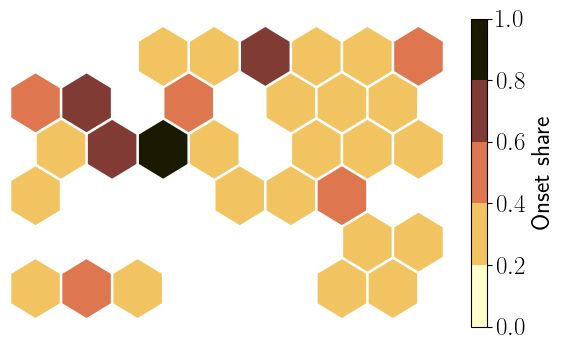

In [31]:
to_plot = np.asarray([np.mean([hs[2] / 24 for hs in cluhs]) for cluhs in clustered_hotspells])
cmap = colormaps.lajolla
kwargs = {
    "cmap": cmap,
    "norm": BoundaryNorm(np.arange(0, 1.2, .2), cmap.N)
}
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
fig, ax = net.plot_on_map(
    to_plot,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=ax,
    draw_cbar=False,
    **kwargs,
)
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=ax, label="Onset share")
plt.show()
